In [5]:
from pylab import *
%matplotlib inline

Se utiliza el metodo de Runge Kutta con argumentos

In [6]:
def rk4(ec,p_ini,x,args=0,h=0.01):  
    if (x[1]-x[0]) <= 5*h:
        h = (x[1]-x[0])/10
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    if args==0:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i])
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    else:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i],args)
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    return tiempos,sol

Se tiene una partícula de masa m = 1 en un campo gravitacional $\: \vec g = −9.8\hat{j}$ en una caja con L = 10 m y d = 3 m. Realice los ejercicios con valores de α = π/6 y
α = π/10

Se define la ecuacion de movimiento de la particula de masa m = 1.
$$ \vec F = -mg\hat{j} - \vec f_{fric} $$

In [7]:
def e_mov(r_v,t,fric=0,g=9.8,m=1):
    dx = r_v[2]
    dy = r_v[3]
    if fric == 0:
        dvx,dvy = 0,-(g)
        # No se uso un modelo de friccion
    else:
        dvx = - (fric([r_v[2],r_v[3]])[0])/m
        dvy = -(g) - (fric([r_v[2],r_v[3]])[1])/m
        # Se uso un modelo de friccion
    return array([dx,dy,dvx,dvy])

Se define el modelo de friccion
$$ \vec f_{fric} = -\gamma \vec v $$ $$ \gamma = 0.1 $$

In [8]:
def fric_v(v,gamma=0.1): # la fricción con el aire es proporcional a la velocidad.
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y]) 

Se defienieron 4 funciones de rebote, una para cada pared de la caja

In [9]:
def rebote(r_v_i,mi_dt,fric,a,plano):# rebote en la base de la caja
    dt_busqueda = (mi_dt)/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],fric)
    y_med = sol[-1,:]
    while abs(y_izq[1]) > abs(plano):# es esta parte si el vector posicion de la pelota esta por ariba del plano 
        # que forma la base de la caja entra al ciclo, este es el unico cambio que se le hizo a el algoritmo visto en clase
        reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(e_mov,reinicio,[0,dt_busqueda],fric)
        y_izq = reinicio
        y_med = sol[-1,:]
    if  y_izq[0] < 5:   
        v_norm =   sin(a),cos(a) # se define un vector perpendicular al plano base de la caja
        v_ori = 1,0 # se define un vector horizontal
        d = 1 # define el sentido de la rotacion 
    else:
        v_norm =  -sin(a),cos(a) # se define un vector perpendicular al plano base de la caja
        v_ori = -1,0 # se define un vector horizontal 
        d = -1 # define el sentido de la rotacion 
    ang = arccos((-v_norm[0]*y_izq[2] - v_norm[1]*y_izq[3])/(sqrt(y_izq[2]**2 + y_izq[3]**2)))
    # Este es el angulo entre el vector  negativo de la velocidad  y el vector perpendicular a la superfice de rebote
    ang_aux = arccos((-v_ori[0]*y_izq[2] - v_ori[1]*y_izq[3])/(sqrt(y_izq[2]**2 + y_izq[3]**2)))
    # Este es el angulo entre el vector  negativo de la velocidad  y el vector tangencial a la superfice de rebote
    if ang_aux > (pi/2-a):# Si el angulo auxiliar es mayor a 90° - a el vector revotara en un angulo negativo respecto al vector normal
        ang=-d*ang
    else: # Si el angulo auxiliar es menor a 90° - a el vector revotara en un angulo positivo respecto al vector normal
        ang= d*ang
    y_izq2 =  -cos(2*ang)*(y_izq[2]) + sin(2*ang)*(y_izq[3]) # una matriz de rotacion de 2(ang) aplicada al vector velocidad  
    y_izq3 =  -sin(2*ang)*(y_izq[2]) - cos(2*ang)*(y_izq[3]) # repecto al vector perpendicular al plano base de la caja
    y_izq = array([y_izq[0],y_izq[1],y_izq2,y_izq3])  
    return y_izq


In [10]:
def rebote2(r_v_i,mi_dt,fric):# rebote en la pared derecha de la caja
    dt_busqueda = (mi_dt)/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],fric)
    y_med = sol[-1,:]
    while abs(y_izq[0]) > 10: # en esta parte si abs(y_izq[1]) esta por fuera de la pared derecha entra al ciclo
        # este es el algoritmo de rebote visto en clase
        reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(e_mov,reinicio,[0,dt_busqueda],fric)
        y_izq = reinicio
        y_med = sol[-1,:]  
    y_izq = array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])    
    return y_izq

In [11]:
def rebote3(r_v_i,mi_dt,fric):# rebote en la pared izquierda de la caja
    dt_busqueda = (mi_dt)/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],fric)
    y_med = sol[-1,:]
    while abs(y_izq[0]) < 0: # en esta parte si abs(y_izq[1]) esta por fuera de la pared izquierda entra al ciclo  
        # este es el algoritmo de rebote visto en clase
        reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(e_mov,reinicio,[0,dt_busqueda],fric)
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])    
    return y_izq

In [12]:
def rebote4(r_v_i,mi_dt,fric):# rebote en la tapa de la caja
    dt_busqueda = (mi_dt)/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],fric)
    y_med = sol[-1,:]
    while abs(y_izq[1]) > 5.9: # es esta parte si abs(y_izq[1]) esta por arriba de la tapa de la caja entra al ciclo  
        # este es el algoritmo de rebote visto en clase
        reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(e_mov,reinicio,[0,dt_busqueda],fric)
        y_izq = reinicio
        y_med = sol[-1,:] 
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])    
    return y_izq

Se define una funcíon que describe la base de la caja

In [14]:
def pendiente(angulo): # encuentra la pendiente en funcion del angulo dado
    m = -tan(angulo)
    return m 
def f(x,angulo,h):     # encuentra la recta del plano en funcion del angulo, h es la altura inicial
    if abs(x) <= 5:
        y=x*pendiente(angulo)+h
    else:
        y=-x*pendiente(angulo)-h   
    return y

Se definen dos funcíones (una para cada recta) para graficar la base de la caja

In [15]:
def g(x,angulo,h):     # encuentra la recta del plano en funcion del angulo, h es la altura inicial
    f=x*pendiente(angulo)+h
    return f
def k(z,angulo,h):
    f=-z*pendiente(angulo)-h   
    return f

Se define la funcion dona que busca los puntos de la trayectoria de la pelota dentro de la caja

In [70]:
def caja(a,b,N,norm_v,fric): # las dos primeras entradas corresponden al angulo de la caja y al andulo de lanzamiento de la pelora 
    # N = numero de puntos a calcular dentro de la trayectoria y fric corresponde al modelo de friccion
    r = 0 # contador de rebotes
    v_y = cos(b)*norm_v # define la componente y de la velocidad de la pelota en cuncion del angulo de lanzamiento
    v_x = sin(b)*norm_v # define la componente x de la velocidad de la pelota en cuncion del angulo de lanzamiento
    h = -f(5,a,0) # define la altura inicial de la base de la caja
    x_in = 5./3. # define la posicion inicial de la pelota en la coordenada x
    y_in = f(x_in,a,h) # altura en y  desde donde se hace el lazamiento
    inicio = [x_in,y_in,v_x,v_y] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
    trayectoria = zeros((N,len(inicio)))
    mi_dt = .001
    trayectoria[0,:] = array(inicio)
    for i in range(N-1):
        t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # utiliza la funcion rk4 para encontrar la trayectoria
        plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
        if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
            punto = rebote(trayectoria[i,:],mi_dt,fric,a,plano)
            trayectoria[i+1,:] = punto 
            r +=1
        else:
            trayectoria[i+1,:] = sol_dt[-1,:]      
        if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es mayor a la altura de la tapa la pelota rebota
            punto = rebote4(trayectoria[i,:],mi_dt,fric)
            trayectoria[i+1,:] = punto
            r +=1
        if sol_dt[-1,:][0] > 10: # si la posicion en x de la pelota esta por fuera de la pared derecha la pelota rebota
            punto = rebote2(trayectoria[i,:],mi_dt,fric)
            trayectoria[i+1,:] = punto 
            r +=1
        if sol_dt[-1,:][0] < 0: # si la posicion en x de la pelota esta por fuera de la pared izquierda la pelota rebota
            punto = rebote3(trayectoria[i,:],mi_dt,fric)
            trayectoria[i+1,:] = punto
            r +=1
    print "rebotes =",r
    return trayectoria[:,0],trayectoria[:,1],trayectoria[:,2],trayectoria[:,3]         

a) Realice una simulacíon con condicíon inicial tal que la posicíon inicial está sobre la rampa a un
tercio de la distancia de la pared vertical izquierda y el vértice inferior de la caja, y se dispara
con velocidad $ |\vec v| = 1 $ hacia la derecha con ángulos sobre la horizontal α, 2α y 3α. (Para que la
simulación sea válida, la partícula debe rebotar al menos 20 con alguna parte de la caja).

α = π/6 $$ $$
ángulo sobre la horizontal α

rebotes = 24


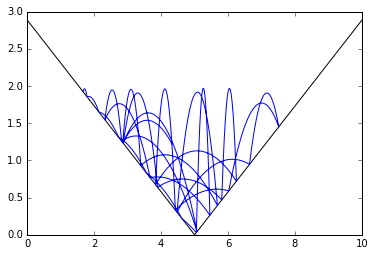

In [88]:
a=pi/6
N=15000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

α = π/10 $$ $$
ángulo sobre la horizontal α

rebotes = 46


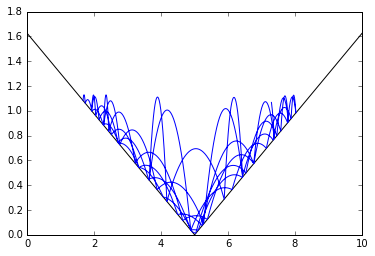

In [90]:
a=pi/10
N=18000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los punto de la trayectoria                                                        # y el plano donde rebota la pelota
show()

α = π/6 $$ $$
ángulo sobre la horizontal 2α

rebotes = 25


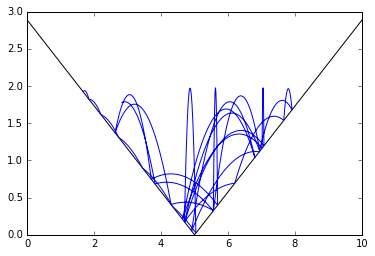

In [91]:
a=pi/6
N=15000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,2*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los punto de la trayectoria                                                        # y el plano donde rebota la pelota
show()

α = π/10 $$ $$
ángulo sobre la horizontal 2α

rebotes = 25


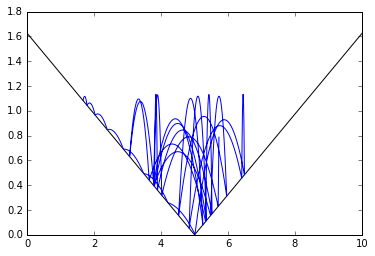

In [93]:
a=pi/10
N=15000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,2*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los punto de la trayectoria                                                        # y el plano donde rebota la pelota
show()

α = π/6 $$ $$
ángulo sobre la horizontal 3α

rebotes = 29


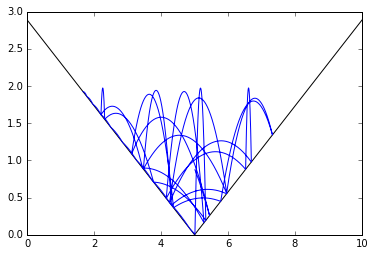

In [95]:
a=pi/6
N=15000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,3*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los punto de la trayectoria                                                        # y el plano donde rebota la pelota
show()

α = π/10 $$ $$
ángulo sobre la horizontal 3α

rebotes = 21


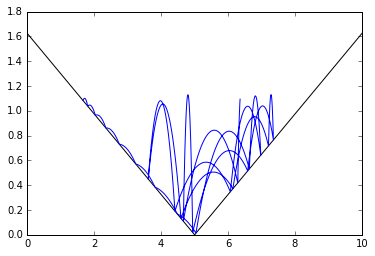

In [97]:
a=pi/10
N=10000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,3*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los punto de la trayectoria                                                        # y el plano donde rebota la pelota
show()

b) Introduzca algún modelo de friccíon y compare las trayectorias con el inciso anterior.

Usando el modelo de friccíon
$$ \vec f_{fric} = -\gamma \vec v $$ $$ \gamma = 0.1 $$

α = π/6 $$ $$
ángulo sobre la horizontal α

rebotes = 35


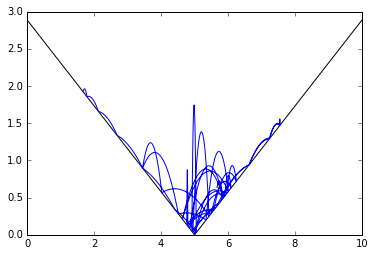

In [98]:
a=pi/6
N=15000
fric=fric_v 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los punto de la trayectoria                                                        # y el plano donde rebota la pelota
show()

α = π/10 $$ $$
ángulo sobre la horizontal α

rebotes = 23


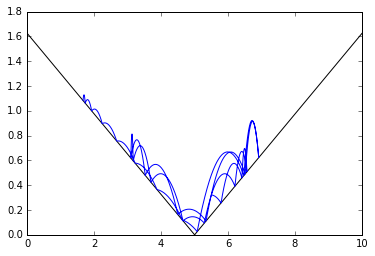

In [99]:
a=pi/10
N=8000
fric=fric_v 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los punto de la trayectoria                                                        # y el plano donde rebota la pelota
show()

α = π/6 $$ $$
ángulo sobre la horizontal 2α

rebotes = 29


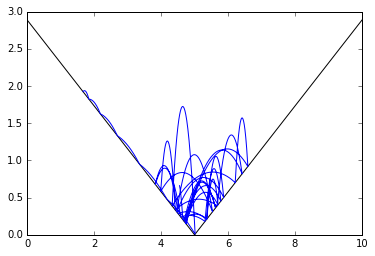

In [100]:
a=pi/6
N=15000
fric=fric_v 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,2*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los punto de la trayectoria                                                        # y el plano donde rebota la pelota
show()

α = π/10 $$ $$
ángulo sobre la horizontal 2α

rebotes = 27


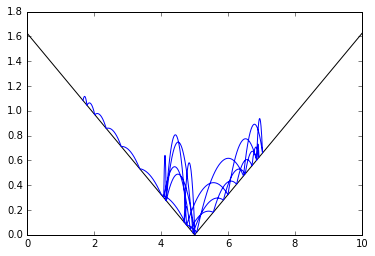

In [102]:
a=pi/10
N=10000
fric=fric_v 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,2*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los punto de la trayectoria                                                        # y el plano donde rebota la pelota
show()

α = π/6 $$ $$
ángulo sobre la horizontal 3α

rebotes = 25


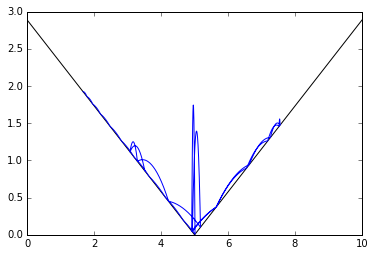

In [103]:
a=pi/6
N=7000
fric=fric_v 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,3*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los punto de la trayectoria                                                        # y el plano donde rebota la pelota
show()

α = π/10 $$ $$
ángulo sobre la horizontal 3α

rebotes = 22


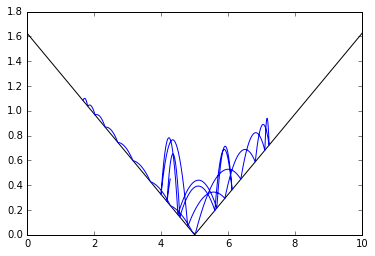

In [104]:
a=pi/10
N=8000
fric=fric_v 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,3*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los punto de la trayectoria                                                        # y el plano donde rebota la pelota
show()

# La diferencia entre las trayectorias sin fricción y con fricción es que en las trayectorias con fricción pierden altura y eventualmente la partícula se ve confinada al vértice central de la caja ya que la energía cinética se va perdiendo. Mientras que en los casos sin fricción las trayectorias no pierden altura y la partícula puede seguir rebotando eternamente ya que la energía se conserva

c) Realice los ejercicios en los incisos (3a) y (3b) pero ahora $|\vec v| = 25 \: y \: |\vec v| = 60 $. Describa las
similitudes y diferencias entre las distintas simulaciones.

a) Sin friccíon

$|\vec v| = 25$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal α

rebotes = 323


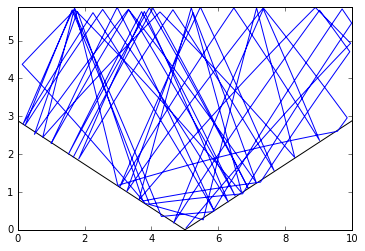

In [57]:
a=pi/6
N=1500
fric=0 
norm_v = 25
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 25$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal α

rebotes = 69


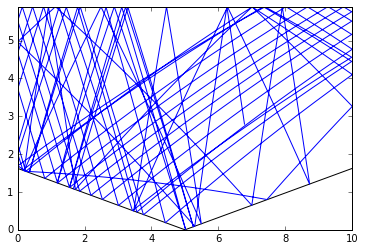

In [105]:
a=pi/10
N=15000
fric=0 
norm_v = 25
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 25$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal 2α

rebotes = 68


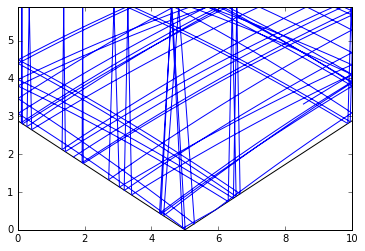

In [106]:
a=pi/6
N=15000
fric=0 
norm_v = 25
h = -f(5,a,0)
sol = caja(a,2*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 25$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal 2α

rebotes = 62


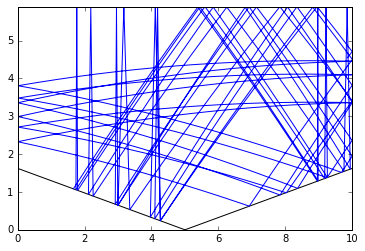

In [107]:
a=pi/10
N=15000
fric=0 
norm_v = 25
h = -f(5,a,0)
sol = caja(a,2*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 25$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal 3α

rebotes = 94


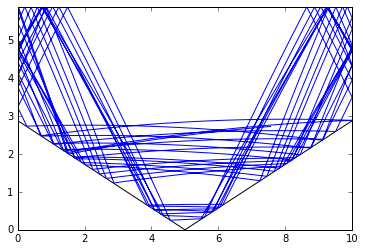

In [108]:
a=pi/6
N=15000
fric=0 
norm_v = 25
h = -f(5,a,0)
sol = caja(a,3*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 25$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal 3α

rebotes = 72


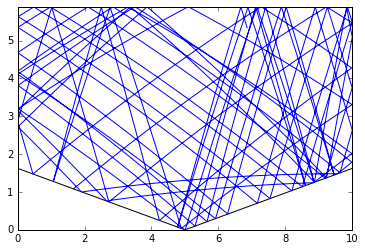

In [109]:
a=pi/10
N=15000
fric=0 
norm_v = 25
h = -f(5,a,0)
sol = caja(a,3*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 60$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal α

rebotes = 65


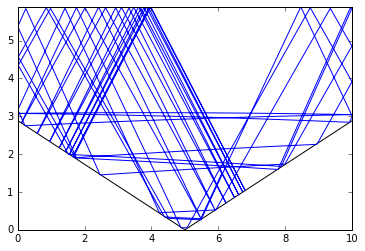

In [79]:
a=pi/6
N=5000
fric=0 
norm_v = 60
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 60$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal α

rebotes = 58


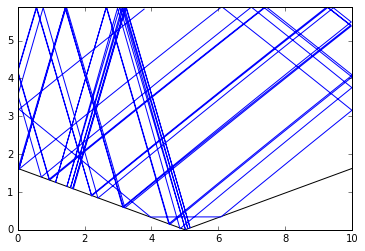

In [80]:
a=pi/10
N=5000
fric=0 
norm_v = 60
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 60$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal 2α

rebotes = 55


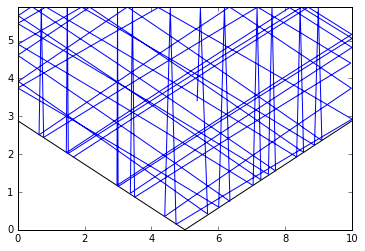

In [81]:
a=pi/6
N=5000
fric=0 
norm_v = 60
h = -f(5,a,0)
sol = caja(a,2*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 60$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal 2α

rebotes = 55


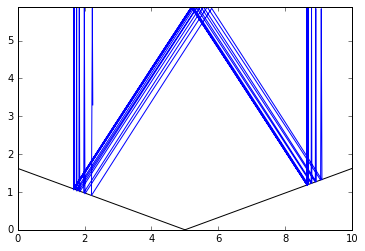

In [82]:
a=pi/10
N=5000
fric=0 
norm_v = 60
h = -f(5,a,0)
sol = caja(a,2*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 60$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal 3α

rebotes = 77


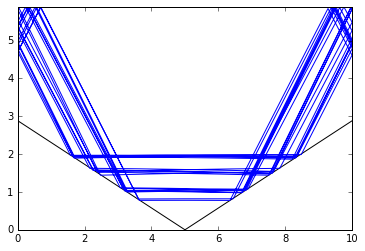

In [83]:
a=pi/6
N=5000
fric=0 
norm_v = 60
h = -f(5,a,0)
sol = caja(a,3*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 60$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal 3α

rebotes = 58


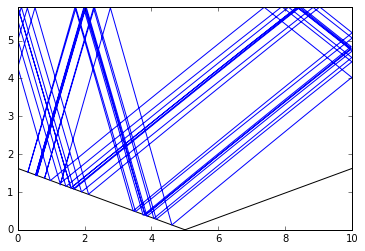

In [84]:
a=pi/10
N=5000
fric=0 
norm_v = 60
h = -f(5,a,0)
sol = caja(a,3*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

b) Usando el modelo de friccíon
$$ \vec f_{fric} = -\gamma \vec v $$ $$ \gamma = 0.1 $$

$|\vec v| = 25$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal α

rebotes = 38


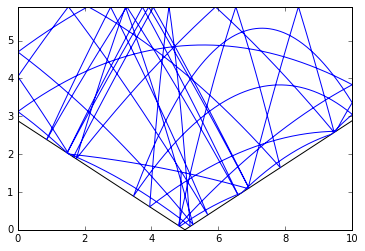

In [113]:
a=pi/6
N=15000
fric=fric_v 
norm_v = 25
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 25$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal α

rebotes = 35


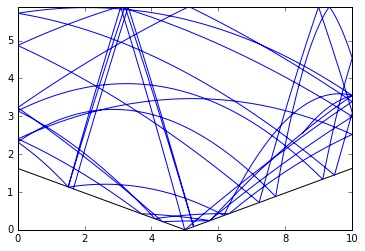

In [114]:
a=pi/10
N=15000
fric=fric_v 
norm_v = 25
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 25$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal 2α

rebotes = 33


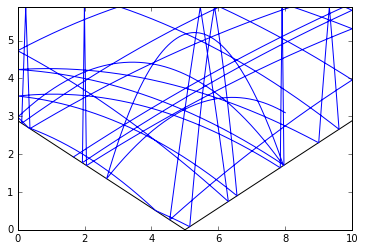

In [115]:
a=pi/6
N=15000
fric=fric_v 
norm_v = 25
h = -f(5,a,0)
sol = caja(a,2*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 25$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal 2α

rebotes = 34


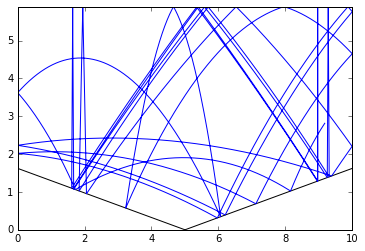

In [116]:
a=pi/10
N=15000
fric=fric_v 
norm_v = 25
h = -f(5,a,0)
sol = caja(a,2*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 25$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal 3α

rebotes = 45


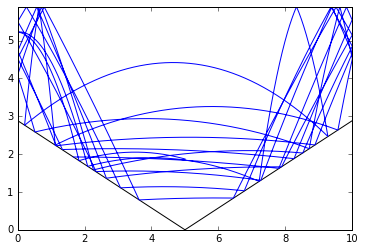

In [117]:
a=pi/6
N=15000
fric=fric_v 
norm_v = 25
h = -f(5,a,0)
sol = caja(a,3*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 25$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal 3α

rebotes = 33


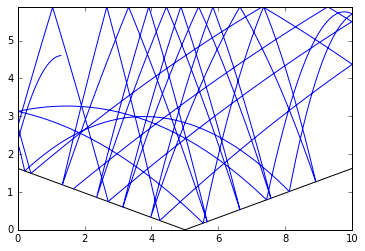

In [118]:
a=pi/10
N=15000
fric=fric_v 
norm_v = 25
h = -f(5,a,0)
sol = caja(a,3*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 60$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal α

rebotes = 99


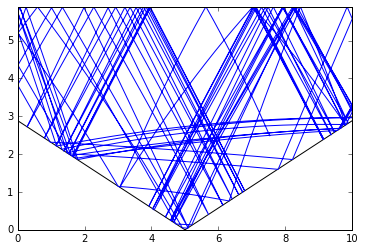

In [135]:
a=pi/6
N=15000
fric=fric_v 
norm_v = 60
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 60$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal α

rebotes = 9


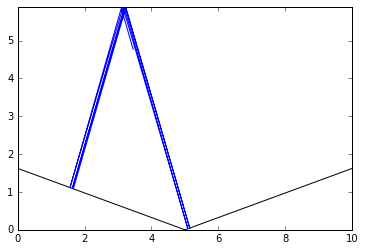

In [134]:
a=pi/10
N=900
fric=fric_v 
norm_v = 60
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 60$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal 2α

rebotes = 83


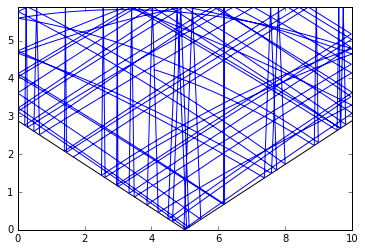

In [124]:
a=pi/6
N=15000
fric=fric_v 
norm_v = 60
h = -f(5,a,0)
sol = caja(a,2*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 60$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal 2α

rebotes = 82


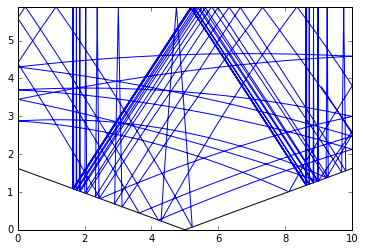

In [123]:
a=pi/10
N=15000
fric=fric_v 
norm_v = 60
h = -f(5,a,0)
sol = caja(a,2*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 60$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal 3α

rebotes = 122


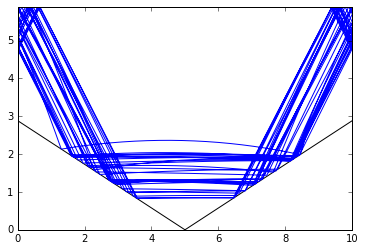

In [121]:
a=pi/6
N=15000
fric=fric_v 
norm_v = 60
h = -f(5,a,0)
sol = caja(a,3*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

$|\vec v| = 60$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal 3α

rebotes = 91


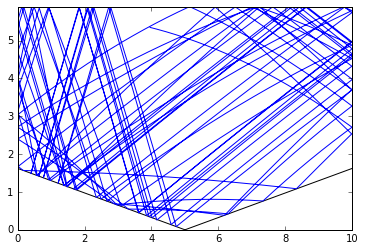

In [122]:
a=pi/10
N=15000
fric=fric_v 
norm_v = 60
h = -f(5,a,0)
sol = caja(a,3*a,N,norm_v,fric)
x=linspace(0,5)
z=linspace(5,10)
ylim(0,5.9)
plot(x,g(x,a,h),'black',z,k(z,a,h),'black')
plot(sol[0],sol[1]) # grafica los puntos de la trayectoria                                                        # y el plano donde rebota la pelota
show()

# La diferencia entre las trayectorias es que entre mas grande es el modulo de velocidad, las trayectorias son mas rectas y los efectos de curvatura debido a la gravedad y la fricción son menores, por otro lado en todos los casos con fricción  eventualmente la partícula perderá energía y se vera confinada al vértice central de la caja, en la simulación esto no es fácil de observar ya que necesitamos un gran numero de puntos para poder observarlo. En los casos sin fricción la partícula puede seguir rebotando eternamente ya que la energía se conserva

d) Dibuje el espacio fase px, x y py, y cuando no hay friccíon y la partícula es lanzada hacia la derecha
a un ángulo α y vertical hacia arriba. Tome en cuenta el número necesario de rebotes para que
la simulacíon pueda barrer el espacio fase de manera representativa.

espacio fase px, x $$ $$
$|\vec v| = 1$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal α

rebotes = 76


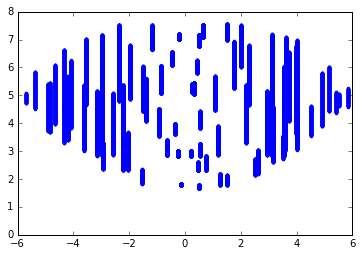

In [162]:
a=pi/6
N=50000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
plot(sol[2],sol[0],'.') 
show()

espacio fase px, x $$ $$
$|\vec v| = 1$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal α

rebotes = 97


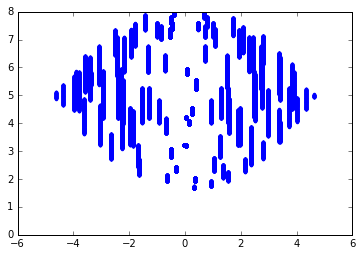

In [161]:
a=pi/10
N=50000
fric=0
norm_v = 1
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
plot(sol[2],sol[0],'.') 
show()

espacio fase py, y $$ $$
$|\vec v| = 1$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal α

rebotes = 37


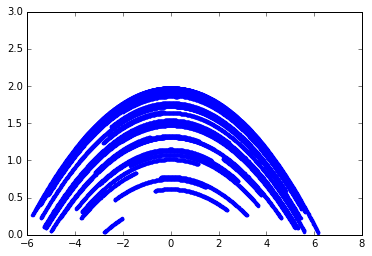

In [148]:
a=pi/6
N=25000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
plot(sol[3],sol[1],'.') 
show()

espacio fase py, y $$ $$
$|\vec v| = 1$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal α

rebotes = 65


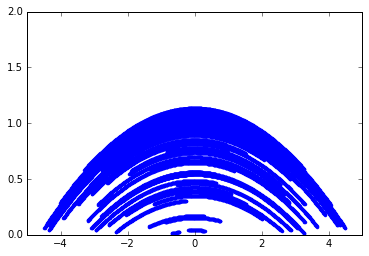

In [151]:
a=pi/10
N=30000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,a,N,norm_v,fric)
plot(sol[3],sol[1],'.') 
show()

espacio fase px, x $$ $$
$|\vec v| = 1$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal π/2

rebotes = 80


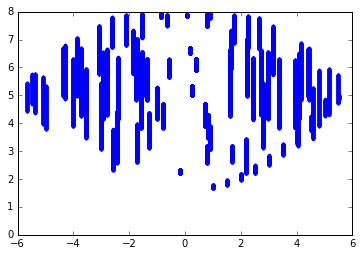

In [155]:
a=pi/6
N=50000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,pi/2,N,norm_v,fric)
plot(sol[2],sol[0],'.')   
ylim(0,8)
show()

espacio fase px, x $$ $$
$|\vec v| = 1$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal π/2

rebotes = 96


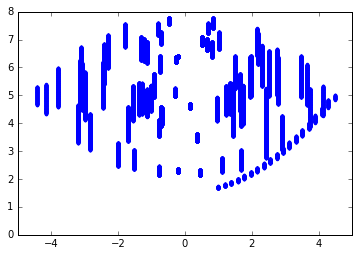

In [159]:
a=pi/10
N=50000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,pi/2,N,norm_v,fric)
plot(sol[2],sol[0],'.') 
show()

espacio fase py, y $$ $$
$|\vec v| = 1$ $$ $$
α = π/6 $$ $$
ángulo sobre la horizontal π/2

rebotes = 80


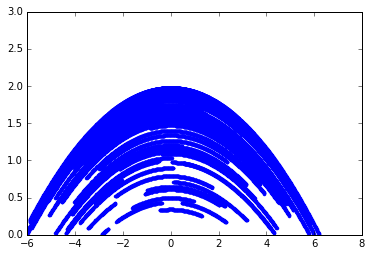

In [158]:
a=pi/6
N=50000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,pi/2,N,norm_v,fric)
plot(sol[3],sol[1],'.')    
show()

espacio fase py, y $$ $$
$|\vec v| = 1$ $$ $$
α = π/10 $$ $$
ángulo sobre la horizontal π/2

rebotes = 96


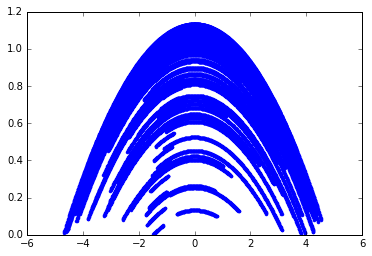

In [164]:
a=pi/10
N=50000
fric=0 
norm_v = 1
h = -f(5,a,0)
sol = caja(a,pi/2,N,norm_v,fric)
plot(sol[3],sol[1],'.')   
show()

#  Independientemente de las condiciones iniciales de lanzamiento (angulo) el espacio face es muy similar, y entre mas rebotes tendremos un mejor barrido para los espacios fase 